Movies dataset shape: (9742, 3)
Ratings dataset shape: (100836, 4)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Rating distribution:


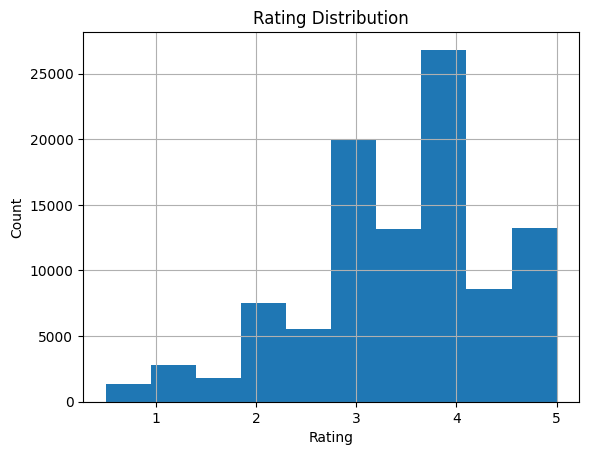


Content-based recommendations for 'Toy Story (1995)':
['Antz (1998)', 'Toy Story 2 (1999)', 'Adventures of Rocky and Bullwinkle, The (2000)', "Emperor's New Groove, The (2000)", 'Monsters, Inc. (2001)']

Collaborative filtering recommendations for 'Jumanji (1995)':
['Lion King, The (1994)', 'Mrs. Doubtfire (1993)', 'Mask, The (1994)', 'Jurassic Park (1993)', 'Home Alone (1990)']

Top 10 popular movies (avg rating with >=50 ratings):


,title,avg_rating,rating_count
movieId,,,
318,"Shawshank Redemption, The (1994)",4.429022,317.0
858,"Godfather, The (1972)",4.289062,192.0
2959,Fight Club (1999),4.272936,218.0
1276,Cool Hand Luke (1967),4.271930,57.0
750,Dr. Strangelove or: How I Learned to Stop Worr...,4.268041,97.0
904,Rear Window (1954),4.261905,84.0
1221,"Godfather: Part II, The (1974)",4.259690,129.0
48516,"Departed, The (2006)",4.252336,107.0
1213,Goodfellas (1990),4.250000,126.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# Load data
movies = pd.read_csv("D:/INTERNSHIP/movie recommendation/movies.csv")
ratings = pd.read_csv("D:/INTERNSHIP/movie recommendation/ratings.csv")

print("Movies dataset shape:", movies.shape)
print("Ratings dataset shape:", ratings.shape)


display(movies.head())
display(ratings.head())


print("Missing values in movies:")
print(movies.isnull().sum())
print("\nMissing values in ratings:")
print(ratings.isnull().sum())

print("\nRating distribution:")
ratings['rating'].hist(bins=10)

plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'].fillna(''))

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_content_recommendations(title, top_n=5):
    indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()
    
    if title not in indices:
        return ["Movie not found in dataset."]
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices].tolist()

print("\nContent-based recommendations for 'Toy Story (1995)':")
print(get_content_recommendations("Toy Story (1995)"))


user_movie_matrix = ratings.merge(movies, on='movieId')
pivot_table = user_movie_matrix.pivot_table(index='userId', columns='title', values='rating').fillna(0)

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(pivot_table.T.values)

def get_collaborative_recommendations(title, top_n=5):
    if title not in pivot_table.columns:
        return ["Movie not rated by enough users."]
    
    query_index = list(pivot_table.columns).index(title)
    distances, indices = model_knn.kneighbors([pivot_table.T.values[query_index]], n_neighbors=top_n+1)
    
    recs = [pivot_table.columns[i] for i in indices.flatten()]
    return recs[1:]  # Exclude the movie itself

print("\nCollaborative filtering recommendations for 'Jumanji (1995)':")
print(get_collaborative_recommendations("Jumanji (1995)"))

avg_ratings = ratings.groupby('movieId')['rating'].mean().rename('avg_rating')
count_ratings = ratings.groupby('movieId')['rating'].count().rename('rating_count')

popular_movies = movies.set_index('movieId').join(avg_ratings).join(count_ratings)
popular_movies = popular_movies[popular_movies['rating_count'] >= 50].sort_values('avg_rating', ascending=False)

print("\nTop 10 popular movies (avg rating with >=50 ratings):")
display(popular_movies[['title', 'avg_rating', 'rating_count']].head(10))
